In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
device = torch.device("cpu")
import torch
import torch.func as TF
from functorch import jacrev,jacfwd
import matplotlib.pyplot as plt
import timeit

# I. Setting different ways of metric computation for the decoder

In [2]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x
    
decoder = Decoder(encoded_space_dim = 2,fc2_input_dim=128)

# Send to device
decoder.to(device) 

# Load the parameters of the trained decoder without curvature in Loss func
PATH_dec = '../nn_weights/decoder_conv_autoenc.pt'
decoder.load_state_dict(torch.load(PATH_dec))

# Switch to eval mode
decoder.eval()

Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [3]:
def make_grid(numsteps):
    
    xs = torch.linspace(-1.5, 1.5, steps = numsteps)
    ys = torch.linspace(-1.5, 1.5, steps = numsteps)
    #uniform_grid = torch.cartesian_prod(xs,ys)

    # true grid starts from left bottom corner. x is the first to increase
    tgrid = torch.cartesian_prod(ys, xs)
    tgrid = tgrid.roll(1,1)
    return tgrid

In [4]:
def metric_fd(u, function=decoder, hx=1e-5, hy=1e-5): #this gives metric at point u with steps hx and hy
    u = u.reshape(-1,2)

    dx = torch.tensor([[0.0 + hx, 0.0]])
    dy = torch.tensor([[0.0, 0.0 + hy]])
    dpsi_over_dx = (function(u + dx) - function(u - dx))/(2*hx)
    dpsi_over_dy = (function(u + dy) - function(u - dy))/(2*hy)

    dpsi_over_dx = torch.flatten(dpsi_over_dx).view(784,1)
    dpsi_over_dy = torch.flatten(dpsi_over_dy).view(784,1)
    
    dpsi = torch.cat((dpsi_over_dx,dpsi_over_dy),dim=-1)
    my_metric = torch.matmul(dpsi.T,dpsi)
    return my_metric

# metric computation with f.d. vectorized (by hand)
def metric_fd_vectorized(u, function=decoder, hx=1e-4, hy=1e-4): #this gives metric at point u with steps hx and hy
    u = u.reshape(-1,2)

    dx = torch.tensor([[0.0 + hx, 0.0]])
    dy = torch.tensor([[0.0, 0.0 + hy]])
    dpsi_over_dx = (function(u + dx) - function(u - dx))/(2*hx)
    dpsi_over_dy = (function(u + dy) - function(u - dy))/(2*hy)

    dpsi_over_dx = dpsi_over_dx.view(-1,784,1)
    dpsi_over_dy = dpsi_over_dy.view(-1,784,1)
    
    dpsi = torch.cat((dpsi_over_dx,dpsi_over_dy),dim=-1)
    my_metric = torch.matmul(dpsi.transpose(-2,-1),dpsi)
    return my_metric

def metric_jacfwd(u, function = decoder):
    u = u.reshape(-1,2)
    jac = jacfwd(function)(u)
    jac = jac.reshape(-1,2)
    metric = torch.matmul(jac.T,jac)
    return metric

def metric_jacrev(u, function = decoder):
    u = u.reshape(-1,2)
    jac = jacrev(function)(u)
    jac = jac.reshape(-1,2)
    metric = torch.matmul(jac.T,jac)
    return metric

metric_fd_vmap = TF.vmap(metric_fd)
metric_jacfwd_vmap = TF.vmap(metric_jacfwd)
metric_jacrev_vmap = TF.vmap(metric_jacrev)


In [5]:
def compute_metric(function=decoder, batch = None, method ={"name":str, "precision":float}):
    if method["name"]=="metric_jacfwd_vmap":
        return metric_jacfwd_vmap(batch, function=function)
    elif method["name"]=="metric_fd_vmap":
        h = method["precision"]
        with torch.no_grad():
            metric = metric_fd_vmap(batch, function=function, hx=h,hy=h)
        return metric
    elif method["name"]=="metric_jacrev_vmap":
        return metric_jacrev_vmap(batch, function=function)
    elif method["name"]=="metric_fd_vectorized":
        h = method["precision"]
        with torch.no_grad():
            metric = metric_fd_vectorized(batch, function=function, hx=h,hy=h)
        return metric

In [6]:
# a short demo checking if this works
my_batch = torch.rand(2,2)
example_fd_vmap = compute_metric(decoder, my_batch, method={"name": "metric_fd_vmap", "precision" : 1e-4})
example_fd_vectorized = compute_metric(decoder, my_batch, method={"name": "metric_fd_vectorized", "precision" : 1e-4})
example_jacfwd_vmap = compute_metric(decoder, my_batch, method={"name": "metric_jacfwd_vmap", "precision" : None})
example_jacrev_vmap = compute_metric(decoder, my_batch, method={"name": "metric_jacrev_vmap", "precision" : None})
print("fd+vmap:\n",example_fd_vmap,
      "\n fd_vectorized:\n",example_fd_vectorized,
      "\n jacfwd+vmap:\n",example_jacfwd_vmap,
      "\n jacrev+vmap:\n",example_jacrev_vmap)

fd+vmap:
 tensor([[[ 57.8126, -20.5800],
         [-20.5800,  31.7593]],

        [[102.2853, -28.4329],
         [-28.4329,  71.0864]]]) 
 fd_vectorized:
 tensor([[[ 57.8005, -20.5849],
         [-20.5849,  31.7550]],

        [[102.2793, -28.4498],
         [-28.4498,  71.0912]]]) 
 jacfwd+vmap:
 tensor([[[ 57.8384, -20.5944],
         [-20.5944,  31.7477]],

        [[102.2351, -28.4329],
         [-28.4329,  71.1395]]], grad_fn=<UnsafeViewBackward0>) 
 jacrev+vmap:
 tensor([[[ 57.8384, -20.5944],
         [-20.5944,  31.7477]],

        [[102.2350, -28.4329],
         [-28.4329,  71.1394]]], grad_fn=<UnsafeViewBackward0>)


/home/alazarev/CodeProjects/ricci_regularization/.venv_ricci/lib/python3.10/site-packages/torch-2.0.1-py3.10-linux-x86_64.egg/torch/_functorch/deprecated.py:85: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacfwd is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacfwd instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacfwd')
/home/alazarev/CodeProjects/ricci_regularization/.venv_ricci/lib/python3.10/site-packages/torch-2.0.1-py3.10-linux-x86_64.egg/torch/_functorch/deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes

# II.Testing: performance plots

In [7]:
batchsize_array = np.linspace(10,9e+4+10,num=6).astype(int)
batchsize_array


array([   10, 18010, 36010, 54010, 72010, 90010])

In [8]:
computation_time_fd =[]
computation_time_fd_vectorized =[]
#computation_time_jacrev =[]
computation_time_jacfwd =[]

for i in batchsize_array:
    numsteps = i
    my_batch = torch.rand(i,2)

    with_fd_timer = timeit.timeit(stmt="compute_metric(decoder, my_batch, method={\"name\": \"metric_fd_vmap\", \"precision\" : 1e-4})",number=1,globals=globals())
    with_fd_vectorized_timer = timeit.timeit(stmt="compute_metric(decoder, my_batch, method={\"name\": \"metric_fd_vectorized\", \"precision\" : 1e-4})",number=1,globals=globals())
    with_jacfwd_timer = timeit.timeit(stmt="compute_metric(decoder, my_batch, method={\"name\": \"metric_jacfwd_vmap\", \"precision\" : None})",number=1, globals=globals())
    #with_jacrev_timer = timeit.timeit(stmt="compute_metric(decoder, my_batch, method={\"name\": \"metric_jacrev_vmap\", \"precision\" : None})",number=1, globals=globals())
    #computation_time_jacrev.append(with_jacrev_timer)
    computation_time_fd.append(with_fd_timer)
    computation_time_fd_vectorized.append(with_fd_timer)
    computation_time_jacfwd.append(with_jacfwd_timer)

In [9]:
# fd+vmap and fd_vectorized are identical in performance 
np.array(computation_time_fd_vectorized)-np.array(computation_time_fd)

array([0., 0., 0., 0., 0., 0.])

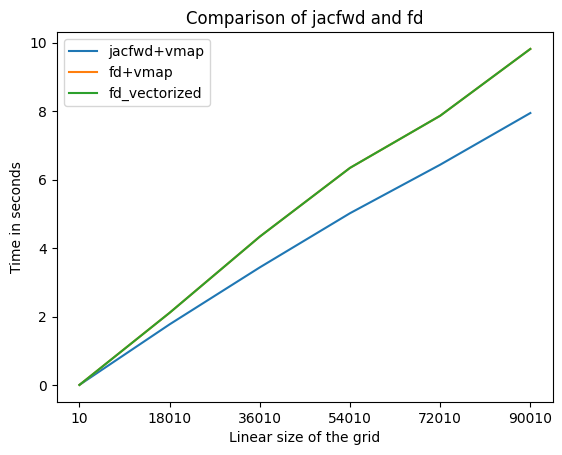

In [10]:
plt.plot(computation_time_jacfwd,label="jacfwd+vmap")
plt.plot(computation_time_fd,label="fd+vmap")
plt.plot(computation_time_fd_vectorized,label="fd_vectorized")
#plt.plot(computation_time_jacrev,label="jacrev+vmap")
plt.xticks((batchsize_array-10)/18000, labels=batchsize_array)
plt.title("Comparison of jacfwd and fd")
plt.xlabel("Linear size of the grid")
plt.ylabel("Time in seconds")
plt.legend()
plt.show()

# III. Testing: relative error of fd vs jacfwd

In [11]:
numsteps = 100
fd_step = 5e-6 
tgrid = make_grid(numsteps)
metric_on_grid_jacfwd = compute_metric(decoder, tgrid, method={"name": "metric_jacfwd_vmap", "precision" : None})
metric_on_grid_jacfwd = metric_on_grid_jacfwd.detach()
metric_on_grid_fd = compute_metric(decoder, tgrid, method={"name": "metric_fd_vmap", "precision" : fd_step})

In [12]:
xs = torch.linspace(-1.5, 1.5, steps = numsteps)
ys = torch.linspace(-1.5, 1.5, steps = numsteps)

# Fast computation of Frobenious norm on the grid without borders
Newfrob1 = metric_on_grid_jacfwd.norm(dim=(1,2)).view(numsteps,numsteps)
Newfrob1 = Newfrob1[1:-1,1:-1].transpose(0,1)

Newfrob2 = metric_on_grid_fd.norm(dim=(1,2)).view(numsteps,numsteps)
Newfrob2 = Newfrob2[1:-1,1:-1].transpose(0,1)


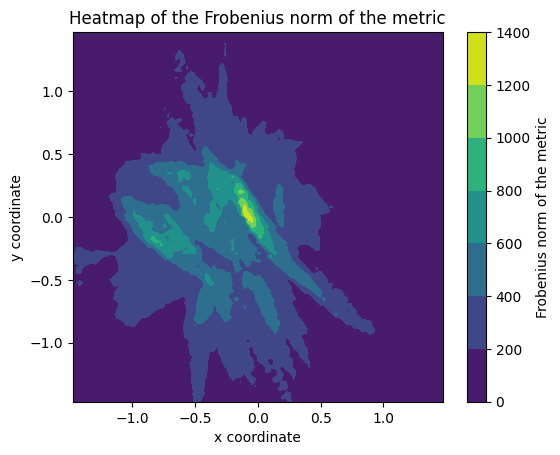

In [13]:
#Heat map of the frobenius norm
h = plt.contourf(xs[1:-1], ys[1:-1], Newfrob1)
plt.title('Heatmap of the Frobenius norm of the metric')
plt.xlabel( "x coordinate")
plt.ylabel( "y coordinate")
plt.axis('scaled')
plt.colorbar(label="Frobenius norm of the metric")
#plt.xlim(-1.5 + mean[0], 1.5 + mean[0])
#plt.ylim(-1.5 + mean[1], 1.5 + mean[1])
plt.show()

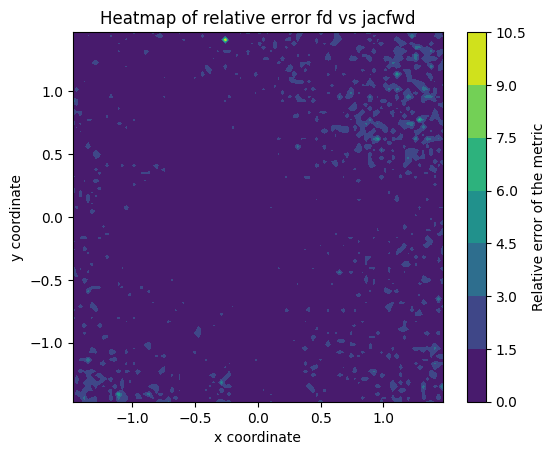

In [21]:
#Heat map of the frobenius norm
h = plt.contourf(xs[1:-1], ys[1:-1], 100*abs(Newfrob1-Newfrob2)/Newfrob1)
plt.title('Heatmap of relative error fd vs jacfwd')
plt.xlabel( "x coordinate")
plt.ylabel( "y coordinate")
plt.axis('scaled')
plt.colorbar(label="Relative error of the metric")
#plt.xlim(-1.5 + mean[0], 1.5 + mean[0])
#plt.ylim(-1.5 + mean[1], 1.5 + mean[1])
plt.show()

# IV. Checking ground truth

In [15]:
my_fun_constant = nn.Linear(2,784,bias=False)
weights_tensor = torch.rand(784,2)
Q, R = torch.linalg.qr(weights_tensor)
with torch.no_grad():
    my_fun_constant.weight = nn.Parameter(Q)
def my_fun_sphere(u):
    u = u.flatten()
    output = torch.cat((torch.sin(u[0])*torch.cos(u[1]).unsqueeze(0),torch.sin(u[0])*torch.sin(u[1]).unsqueeze(0),torch.cos(u[0]).unsqueeze(0)),dim=-1)
    output = torch.cat((output.unsqueeze(0),torch.zeros(781).unsqueeze(0)),dim=1)
    output = output.flatten()
    return output

In [16]:
#short demo
my_batch = torch.rand(3,2)
print("constant:\n", compute_metric(my_fun_constant, my_batch, method={"name": "metric_jacfwd_vmap", "precision" : None}),
      "\n spheric coordinates:\n", compute_metric(my_fun_sphere, my_batch, method={"name": "metric_jacfwd_vmap", "precision" : None}))

constant:
 tensor([[[ 1.0000e+00, -7.4506e-09],
         [-7.4506e-09,  1.0000e+00]],

        [[ 1.0000e+00, -7.4506e-09],
         [-7.4506e-09,  1.0000e+00]],

        [[ 1.0000e+00, -7.4506e-09],
         [-7.4506e-09,  1.0000e+00]]], grad_fn=<UnsafeViewBackward0>) 
 spheric coordinates:
 tensor([[[ 1.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  3.0435e-01]],

        [[ 1.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  3.0996e-02]],

        [[ 1.0000e+00, -1.4901e-08],
         [-1.4901e-08,  5.3663e-01]]])


In [17]:
# another way of depicting heatmaps
def draw_metric_frobenius_norm(numsteps=100, function=decoder, method ={"name":str, "precision":float}):
    tgrid = make_grid(numsteps)
    metric_on_grid = compute_metric(function, tgrid, method={"name": method["name"], "precision" : method["precision"]})
    Frob_norm_on_grid = metric_on_grid.norm(dim=(1,2)).view(numsteps,numsteps)
    Frob_norm_on_grid = Frob_norm_on_grid[1:-1,1:-1].detach()
    
    fig, ax = plt.subplots()
    im = ax.imshow(Frob_norm_on_grid,origin="lower")

    cbar = ax.figure.colorbar(im)

    ax.set_xticks((Frob_norm_on_grid.shape[0]-1)*(np.linspace(0,1,num=11)),labels=np.linspace(-1.5,1.5,num=11).round(1))
    ax.set_yticks((Frob_norm_on_grid.shape[1]-1)*(np.linspace(0,1,num=11)),labels=np.linspace(-1.5,1.5,num=11).round(1))
    plt.xlabel( "x coordinate")
    plt.ylabel( "y coordinate")
    plt.axis('scaled')

    ax.set_title("Frobenius norm of the metric")
    fig.tight_layout()
    plt.show()
    return plt

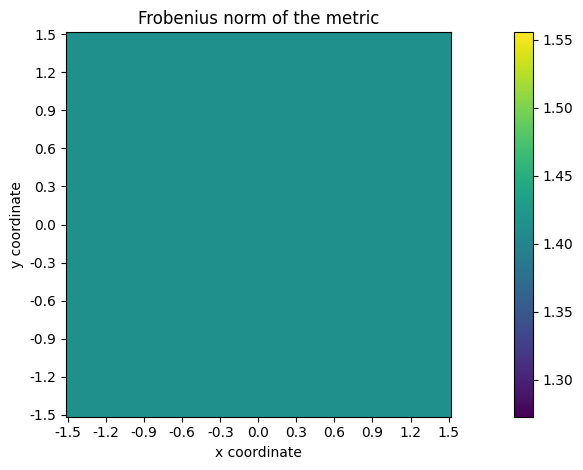

<module 'matplotlib.pyplot' from '/home/alazarev/CodeProjects/ricci_regularization/.venv_ricci/lib/python3.10/site-packages/matplotlib-3.7.2-py3.10-linux-x86_64.egg/matplotlib/pyplot.py'>

In [18]:
draw_metric_frobenius_norm(100,function=my_fun_constant, method={"name": "metric_jacfwd_vmap", "precision" : None})

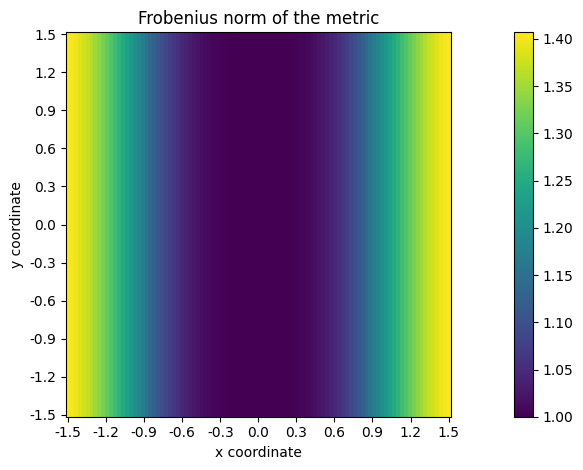

<module 'matplotlib.pyplot' from '/home/alazarev/CodeProjects/ricci_regularization/.venv_ricci/lib/python3.10/site-packages/matplotlib-3.7.2-py3.10-linux-x86_64.egg/matplotlib/pyplot.py'>

In [19]:
draw_metric_frobenius_norm(100,function=my_fun_sphere, method={"name": "metric_jacfwd_vmap", "precision" : None})

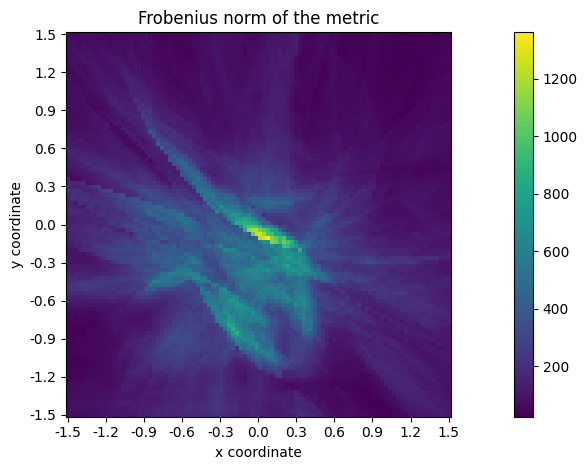

<module 'matplotlib.pyplot' from '/home/alazarev/CodeProjects/ricci_regularization/.venv_ricci/lib/python3.10/site-packages/matplotlib-3.7.2-py3.10-linux-x86_64.egg/matplotlib/pyplot.py'>

In [20]:
draw_metric_frobenius_norm(100,function=decoder, method={"name": "metric_jacfwd_vmap", "precision" : None})